In [100]:
library(tidyverse)
library(broom)
library(AICcmodavg)
# for descriptive analysis
library(psych)
library(vcd)
library(reshape2)
library(sparcl)
library(factoextra)
library(NbClust)
library(xts)
library(mlbench)
library(caret)
library(earth)
library(rpart.plot)
library(xgboost)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [3]:
# Make plots wider 
options(repr.plot.width=15, repr.plot.height=8)

In [3]:

# specifying the path
path <- "C:\\Users\\fatim\\OneDrive\\Documents\\PreScreen_r3_pw - 1234\\PreScreen_r3\\palm_ffb.csv"
 
# reading contents of csv file
df <- read.csv(path)
# rownames(df) <- df$Date
df$Date <- NULL

In [4]:
head(df)

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,616.4,25.30645,21.3,32.2,184.4,25,777778.4,1.62
2,568.9,26.16552,20.9,35.1,140.2,23,767988.3,1.45
3,577.6,25.44839,21.3,32.9,280.4,25,783951.9,1.56
4,581.1,26.90333,20.6,34.8,173.3,25,788987.1,1.39
5,545.4,27.24194,20.9,35.0,140.6,25,813659.7,1.44
6,532.5,27.11667,21.4,35.5,182.3,24,829817.6,1.48


In [70]:
# Check for NaN 
sum(is.na(df))

[1] 0

In [28]:
describe(df)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SoilMoisture,1,130,5.276469e+02,5.736784e+01,538.30000,5.303971e+02,6.182442e+01,380.70000,647.30,2.666000e+02,-0.38528299,-0.340065405,5.031493e+00
Average_Temp,2,130,2.684992e+01,6.514132e-01,26.93065,2.687941e+01,5.923226e-01,25.15806,28.58,3.421935e+00,-0.33278646,0.042611531,5.713272e-02
Min_Temp,3,130,2.137923e+01,6.889714e-01,21.50000,2.144327e+01,5.930400e-01,18.90000,22.60,3.700000e+00,-1.09561293,1.803814290,6.042679e-02
Max_Temp,4,130,3.385154e+01,1.079638e+00,33.90000,3.388173e+01,1.186080e+00,31.10000,36.00,4.900000e+00,-0.21068426,-0.651113690,9.469050e-02
Precipitation,5,130,1.889808e+02,8.023721e+01,182.15000,1.869356e+02,6.390006e+01,2.00000,496.10,4.941000e+02,0.51414552,1.051978001,7.037269e+00
Working_days,6,130,2.475385e+01,1.239289e+00,25.00000,2.484615e+01,1.482600e+00,21.00000,27.00,6.000000e+00,-0.64564310,0.444381740,1.086929e-01
HA_Harvested,7,130,7.934045e+05,3.444089e+04,790036.15805,7.933903e+05,3.535688e+04,683431.94440,882254.23,1.988223e+05,-0.06296501,-0.009633673,3.020666e+03
FFB_Yield,8,130,1.602231e+00,2.817505e-01,1.58500,1.595673e+00,3.039330e-01,1.08000,2.27,1.190000e+00,0.18429830,-0.726614378,2.471116e-02


## Correlation

In [71]:
correlationMatrix <- cor(df,method=c("spearman"))
correlationMatrix

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
SoilMoisture,1.00000000,-0.61115822,0.00809616,-0.46557458,0.53484386,-0.05576789,-0.34651988,-0.05396218
Average_Temp,-0.61115822,1.00000000,0.15014403,0.73561877,-0.31327276,0.06374231,0.49696841,-0.03624881
Min_Temp,0.00809616,0.15014403,1.00000000,-0.16420295,0.36825640,-0.01076735,-0.01667381,0.08428646
Max_Temp,-0.46557458,0.73561877,-0.16420295,1.00000000,-0.42701699,-0.02554927,0.33019538,-0.11052365
Precipitation,0.53484386,-0.31327276,0.36825640,-0.42701699,1.00000000,0.07647087,-0.27653479,0.31194360
Working_days,-0.05576789,0.06374231,-0.01076735,-0.02554927,0.07647087,1.00000000,0.04500142,0.09960629
HA_Harvested,-0.34651988,0.49696841,-0.01667381,0.33019538,-0.27653479,0.04500142,1.00000000,-0.38590262
FFB_Yield,-0.05396218,-0.03624881,0.08428646,-0.11052365,0.31194360,0.09960629,-0.38590262,1.00000000


There is a strong correlation between average temp and max temp; and soil moisture and precipiation.

It is a good idea to remove these before calculating feature importance because they are redundant information.

In [72]:
# find attributes that are highly corrected (ideally >0.75)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.5)
# print indexes of highly correlated attributes
print(highlyCorrelated)

[1] 2 5


In [73]:
df1 <- df[c("SoilMoisture","Min_Temp","Max_Temp","Working_days","HA_Harvested","FFB_Yield")]
correlationMatrix <- cor(df1,method=c("spearman"))
correlationMatrix

# find attributes that are highly corrected (ideally >0.75)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.5)
# print indexes of highly correlated attributes
print(highlyCorrelated)

,SoilMoisture,Min_Temp,Max_Temp,Working_days,HA_Harvested,FFB_Yield
SoilMoisture,1.00000000,0.00809616,-0.46557458,-0.05576789,-0.34651988,-0.05396218
Min_Temp,0.00809616,1.00000000,-0.16420295,-0.01076735,-0.01667381,0.08428646
Max_Temp,-0.46557458,-0.16420295,1.00000000,-0.02554927,0.33019538,-0.11052365
Working_days,-0.05576789,-0.01076735,-0.02554927,1.00000000,0.04500142,0.09960629
HA_Harvested,-0.34651988,-0.01667381,0.33019538,0.04500142,1.00000000,-0.38590262
FFB_Yield,-0.05396218,0.08428646,-0.11052365,0.09960629,-0.38590262,1.00000000


integer(0)


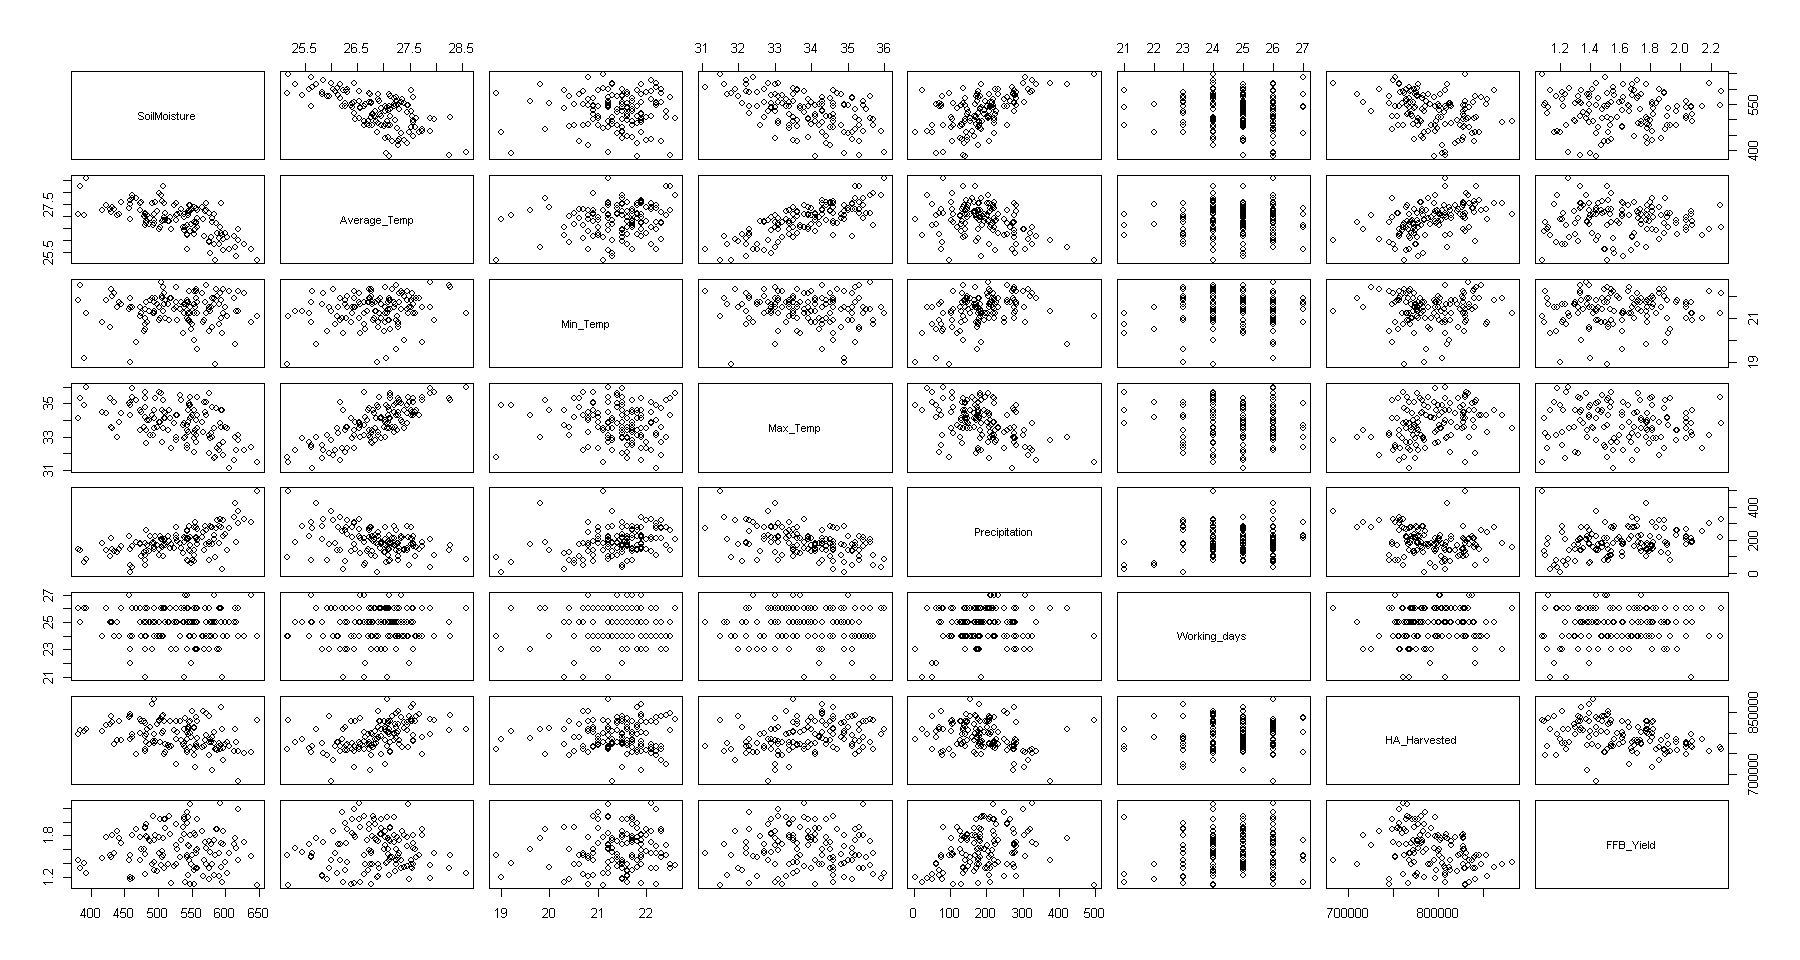

In [38]:
plot(df)

In [67]:
head(df1)

,SoilMoisture,Min_Temp,Max_Temp,Working_days,HA_Harvested,FFB_Yield
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
01.01.2008,616.4,21.3,32.2,25,777778.4,1.62
01.02.2008,568.9,20.9,35.1,23,767988.3,1.45
01.03.2008,577.6,21.3,32.9,25,783951.9,1.56
01.04.2008,581.1,20.6,34.8,25,788987.1,1.39
01.05.2008,545.4,20.9,35.0,25,813659.7,1.44
01.06.2008,532.5,21.4,35.5,24,829817.6,1.48


### Scale data 

In [84]:
df1_s <- data.frame(scale(df1))

### Backwards Feature Selection


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables   RMSE Rsquared    MAE RMSESD RsquaredSD  MAESD Selected
         1 0.9662   0.2172 0.8060 0.2519     0.2240 0.2130         
         2 0.8682   0.2829 0.7007 0.2234     0.2079 0.1943         
         3 0.8516   0.3288 0.6932 0.2083     0.2420 0.1590        *
         4 0.8891   0.2550 0.7183 0.1877     0.2046 0.1509         
         5 0.8582   0.3134 0.6952 0.1712     0.1951 0.1341         

The top 3 variables (out of 3):
   HA_Harvested, SoilMoisture, Max_Temp



[1] "HA_Harvested" "SoilMoisture" "Max_Temp"

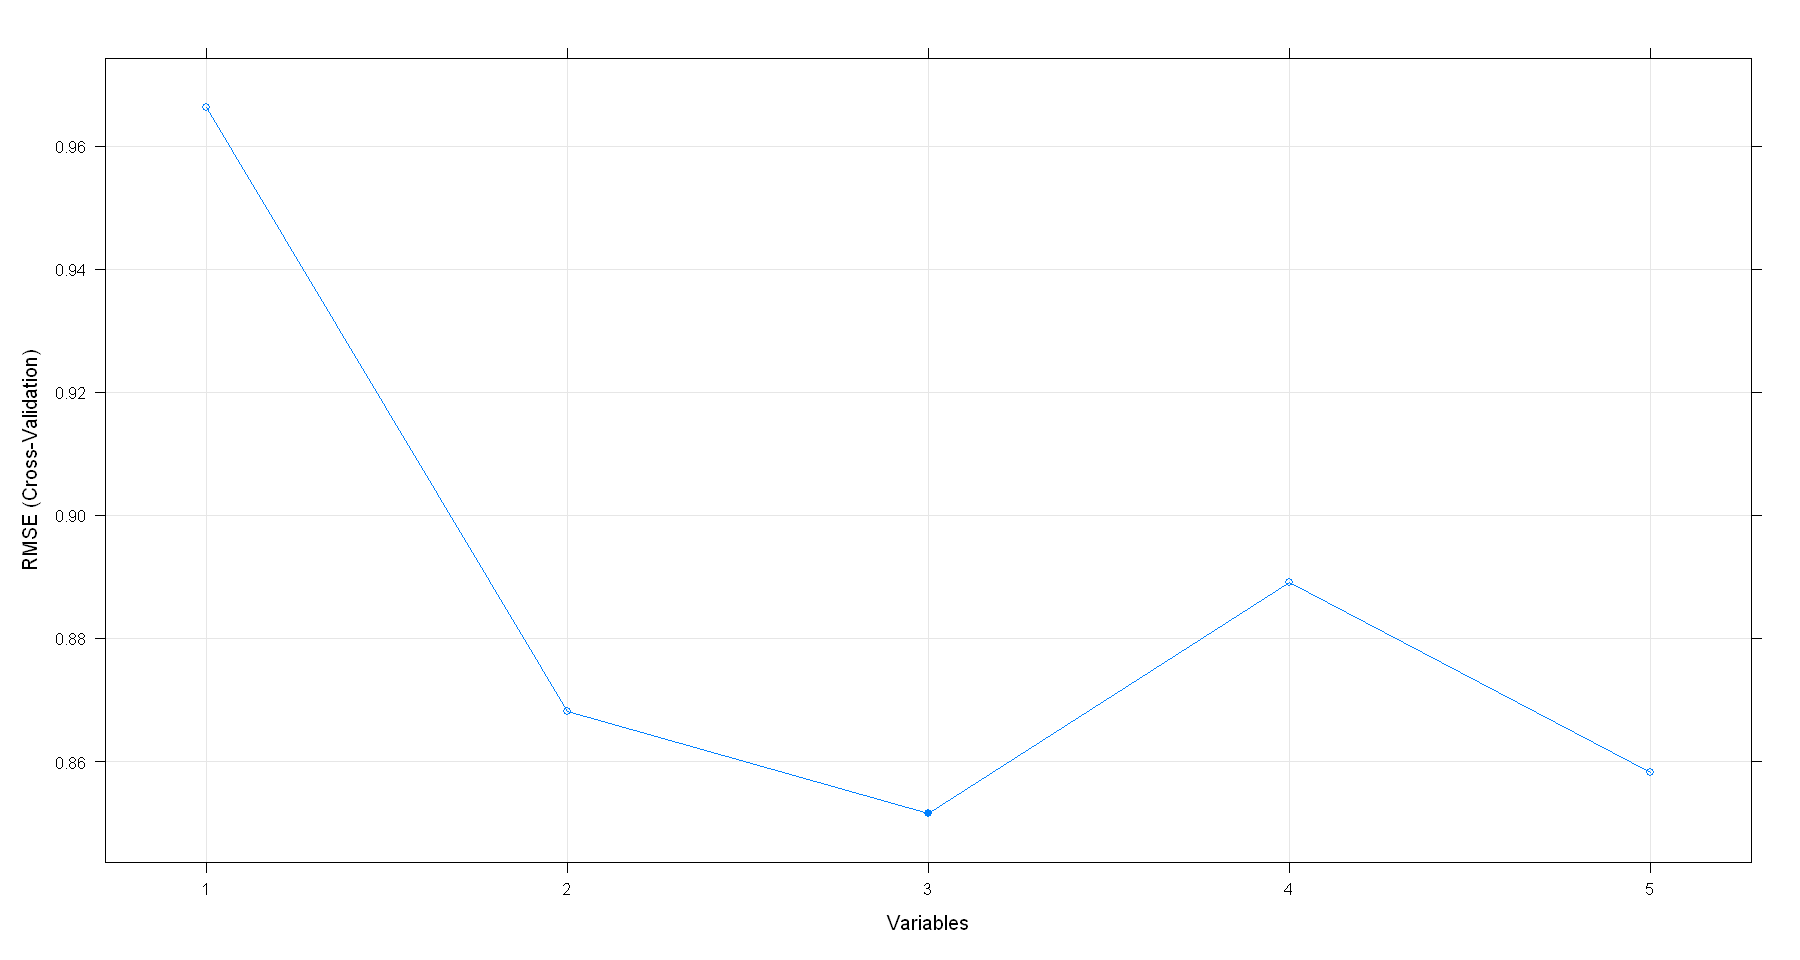

In [88]:
# define the control using a random forest selection function
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
# run the RFE algorithm
results <- rfe(df1_s[,1:5], df1_s[,6], sizes=c(1:8), rfeControl=control)
# summarize the results
print(results)
# list the chosen features
predictors(results)
# plot the results
plot(results, type=c("g", "o"))

In [86]:
marsModel <- earth(FFB_Yield ~ ., data=df1_s) # build model
ev <- evimp (marsModel) 

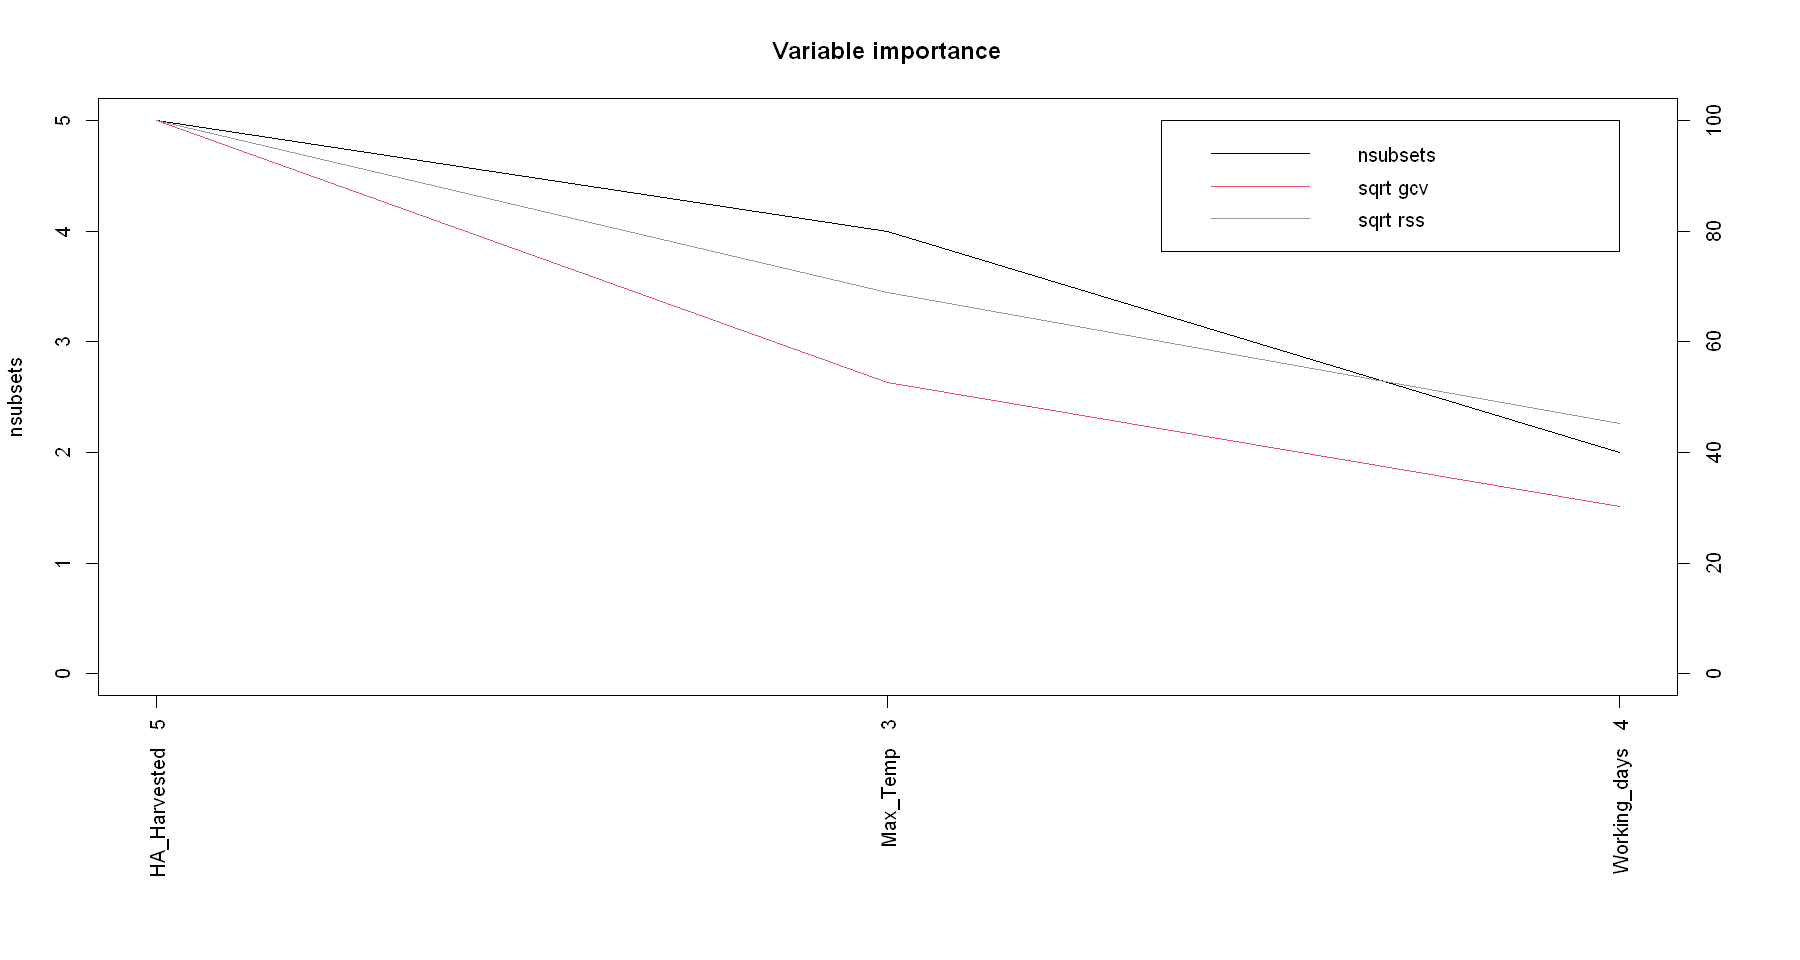

In [80]:
plot(ev)

## Summary

The HA_Harvested has consistent impact on the FFB